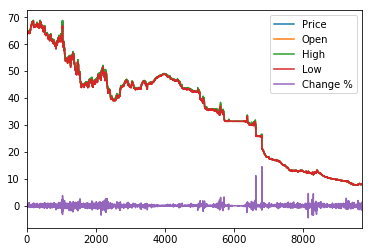

In [8]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
data[:10000].plot() #x='dteday', y='cnt'

In [42]:
# data[:100].plot()
np.array(data).shape

(9697, 6)

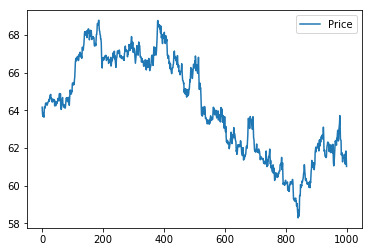

In [43]:
data = np.array(data)
plt.plot(data[:1000, 1], label='Price')
# plt.plot(data[:1000, 2], label='Open')
plt.legend()

In [44]:
# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(data[0:-2, 1]).reshape(-1, 1)
Y_train = np.array(data[1:-1, 1]).reshape(-1, 1)
X_train.shape, Y_train.shape
# # Validation
# X_valid = np.array(watch_txn[-2000:-1000])
# Y_valid = np.array(watch_txn[-2000+1:-1000+1])
# X_valid.shape, Y_valid.shape

# # Testing
# X_test = np.array(watch_txn[-1000:])
# Y_test = np.array(watch_txn[-1000+1:])
# last_row = np.array([np.zeros_like(Y_test[0])])
# Y_test = np.row_stack((Y_test, last_row))
# X_test.shape, Y_test.shape

((9695, 1), (9695, 1))

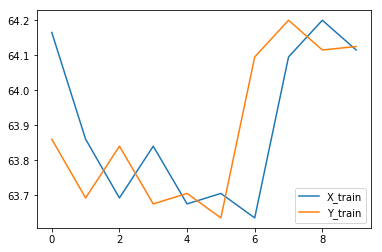

In [45]:
plt.plot(X_train[:10], label='X_train')
plt.plot(Y_train[:10], label='Y_train')
plt.legend()
plt.show()

In [46]:
# Model or Network
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))
    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += l2_regression(y_pred, y)
            dy = dl2_regression(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t])
                for key in grad[l].keys():
                    grads[layer][key] += grad[layer][key]
                
        return grads

In [47]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for _ in range(2):
        M.append([])
        R.append([])
        
    for mode in range(2):
        for layer in range(nn.L):
            M[mode].append({key: np.zeros_like(val) for key, val in nn.model[mode][layer].items()})
            R[mode].append({key: np.zeros_like(val) for key, val in nn.model[mode][layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]            
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test/valid/verifying sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))

    return nn

In [49]:
# hyper parameters
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # print lossof train, valid, or test
time_step = 100 # width of the model or minibatch size
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions

net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X_train, y_train=Y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, 
         print_after=print_after)

KeyError: 0

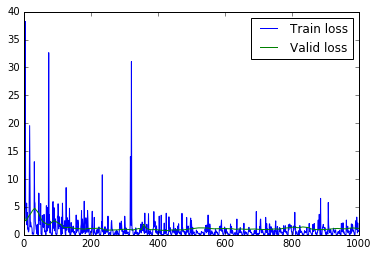

In [13]:
# Display the learning curve and losses for training, validation, and testing
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()

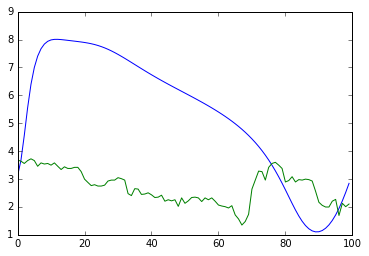

In [15]:
mb = get_minibatch(X=X_valid, y=Y_valid, minibatch_size=time_step, shuffle=False)
# len(mb)
X, Y = mb[len(mb)//100]
X.shape, Y.shape
state = net.initial_state()
X_test = net.test(X_seed=X[0], h=state, size=time_step)
# len(X_test)
X_test = np.array(X_test)
X = np.array(X)
X_test.shape, X.shape
plt.plot(X_test[:, :, 1], label='X_test')
plt.plot(X[:, 1], label='X')